In [1]:
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('RFM_ht_data.csv')
df.shape

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(332730, 4)

In [3]:
df.head()

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     332730 non-null  object        
 1   CustomerCode  332730 non-null  object        
 2   InvoiceDate   332730 non-null  datetime64[ns]
 3   Amount        332730 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 10.2+ MB


In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [9]:
df['InvoiceNo'] = df['InvoiceNo'].apply(str)
df['CustomerCode'] = df['CustomerCode'].apply(str)

In [8]:
df.nunique()

InvoiceNo       332730
CustomerCode    173086
InvoiceDate         30
Amount          143450
dtype: int64

### 1) Какое максимальное кол-во покупок было совершено одним пользователем?

In [18]:
df\
    .groupby('CustomerCode')\
    .agg({'InvoiceNo': 'count'})\
    .sort_values('InvoiceNo', ascending=False).head()

,InvoiceNo
CustomerCode,
19057820,204
13215452,113
13032521,106
19080880,99
99003061,90


## RFM-Analysis

### 2) Какая верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М?
### 3) Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?
### 4) Какое максимальное количество дней может пройти с момента последней покупки для того, чтобы пользователь попал в класс 2 в подсегменте R?

In [14]:
last_date = df.InvoiceDate.max()
last_date

Timestamp('2020-09-30 00:00:00')

In [19]:
rfm_table = df\
    .groupby('CustomerCode')\
    .agg(recency=('InvoiceDate', lambda x: (last_date - x.max()).days),
         frequency=('InvoiceNo', 'count'),
         monetary=('Amount', 'sum'))

In [23]:
quantiles = rfm_table.quantile([.25, .5, .75])
quantiles

,recency,frequency,monetary
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [31]:
list(quantiles['recency'])

[2.0, 8.0, 16.0]

In [43]:
def R_class(value: int, parameter: str, quantile: pd.DataFrame) -> int:
    if value <= quantile[parameter][.25]:
        return 1
    elif value <= quantile[parameter][.5]:
        return 2
    elif value <= quantile[parameter][.75]:
        return 3
    else:
        return 4
    
    
def FM_class(value: int, parameter: str, quantile: pd.DataFrame) -> int:
    if value <= quantile[parameter][.25]:
        return 4
    elif value <= quantile[parameter][.5]:
        return 3
    elif value <= quantile[parameter][.75]:
        return 2
    else:
        return 1

In [46]:
rfm_table['R_class'] = rfm_table['recency'].apply(R_class, args=('recency', quantiles))
rfm_table['F_class'] = rfm_table['frequency'].apply(FM_class, args=('frequency', quantiles))
rfm_table['M_class'] = rfm_table['monetary'].apply(FM_class, args=('monetary', quantiles))

In [48]:
rfm_table['RFM_class'] = rfm_table['R_class'].map(str) + \
                         rfm_table['F_class'].map(str) + \
                         rfm_table['M_class'].map(str)

In [49]:
rfm_table.head()

,recency,frequency,monetary,R_class,F_class,M_class,RFM_class
CustomerCode,,,,,,,
02213019,19,1,1609.20,4,4,3,443
02213042,22,3,9685.48,4,2,1,421
02213071,29,1,415.00,4,4,4,444
02213088,23,1,305.00,4,4,4,444
02213092,25,1,1412.88,4,4,3,443


In [51]:
rfm_table = rfm_table.reset_index()

### 5) Сколько пользователей попало в сегмент 111?
### 6) Сколько пользователей попало в сегмент 311?

In [52]:
rfm_table.query('RFM_class == "111"').shape[0]

9705

In [53]:
rfm_table.query('RFM_class == "311"').shape[0]

1609

### 7) В каком RFM-сегменте самое большое кол-во пользователей?
### 8) В каком RFM-сегменте самое маленькое кол-во пользователей?
### 9) Какое количество пользователей попало в самый малочисленный сегмент?

In [56]:
rfm_table\
    .groupby('RFM_class')\
    .agg({'CustomerCode': 'count'})\
    .sort_values('CustomerCode', ascending=False)

,CustomerCode
RFM_class,
444,10624
111,9705
443,6729
344,6593
211,5847
...,...
424,63
214,60
114,60


### Визуализация RFM-анализа

In [58]:
viz_rfm = rfm_table.pivot_table(index='R_class',
                                columns='F_class',
                                values='monetary',
                                aggfunc='median')\
                   .applymap(int)

In [59]:
viz_rfm

F_class,1,2,3,4
R_class,,,,
1,5768,2733,1805,729
2,4947,2895,1868,814
3,4179,2770,1813,773
4,3822,2682,1813,859


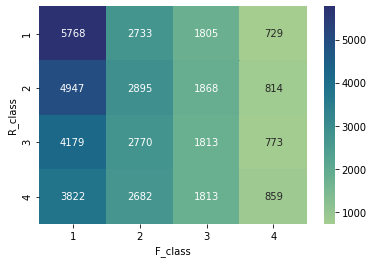

In [68]:
sns.heatmap(viz_rfm, cmap="crest", annot=True, fmt='.0f');